<a href="https://colab.research.google.com/github/00pflint/astr502/blob/master/Patrick%20Flint%20Project%20Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import numpy
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              torchvision.transforms.Resize(60),
                              ])
torchvision.transforms.Resize(60)
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 60, 60])
torch.Size([64])


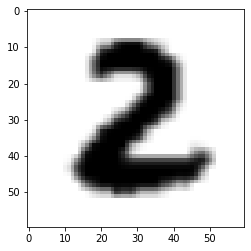

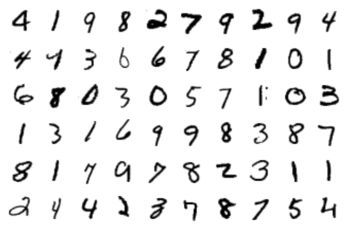

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
# Architecture was modeled after ARCH1 from the paper, using what they said explicitly and making some assumptions for what was not said
net = nn.Sequential(
    # in the paper the first convolutional layer would have taken 3 channel inputs for the 3 different colors
    nn.Conv2d(1, 96, kernel_size=11, stride=1, padding=0), nn.ReLU(),
    # I am uncertain of whether this maxpool layer should be here, but I made an assumption based on their image of the architecture
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(96, 128, kernel_size=5, padding=0), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(128*10*10, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10))


In [ ]:

net.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))
X = torch.randn(1, 1, 60, 60).to(device)

print('Input shape:\t', X.shape)

for layer in net:
    X=layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Total network parameters : 52792906
Input shape:	 torch.Size([1, 1, 60, 60])
Conv2d output shape:	 torch.Size([1, 96, 50, 50])
ReLU output shape:	 torch.Size([1, 96, 50, 50])
MaxPool2d output shape:	 torch.Size([1, 96, 25, 25])
Conv2d output shape:	 torch.Size([1, 128, 21, 21])
ReLU output shape:	 torch.Size([1, 128, 21, 21])
MaxPool2d output shape:	 torch.Size([1, 128, 10, 10])
Flatten output shape:	 torch.Size([1, 12800])
Dropout output shape:	 torch.Size([1, 12800])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


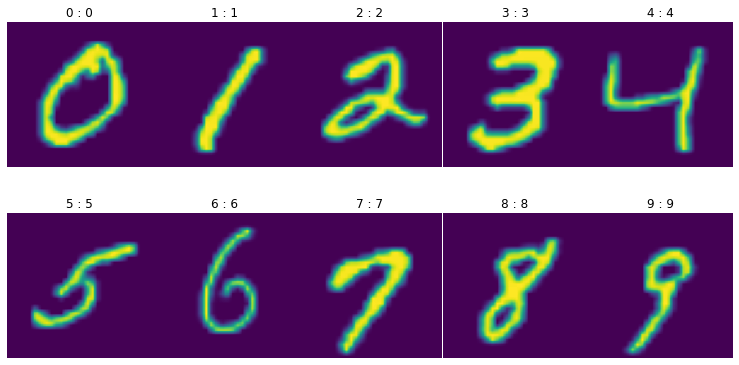

In [ ]:
labels_map = {
    0: "0",    
    1: "1",     
    2: "2",   
    3: "3",      
    4: "4",       
    5: "5",     
    6: "6",      
    7: "7",     
    8: "8",         
    9: "9",  
}

fig, axes = plt.subplots(2, 5, figsize=(13, 7))
plt.subplots_adjust(hspace=0.001, wspace=0.001)

for i, ID in enumerate([1, 3, 5, 7, 2]):
    image, label = trainset.__getitem__(ID)
    axes[0][i].imshow(image.squeeze().numpy())
    axes[0][i].set_title(f'{label} : {labels_map[label]}')
    axes[0][i].axis('off')

for i, ID in enumerate([35, 18, 15, 17, 19]):
    image, label = trainset.__getitem__(ID)
    axes[1][i].imshow(image.squeeze().numpy())
    axes[1][i].set_title(f'{label} : {labels_map[label]}')
    axes[1][i].axis('off')

In [ ]:
# Loss
criterion = nn.CrossEntropyLoss()
# Optimizer
learning_rate = 0.1
# the code from the paper used nesterov momentum = 0.9 but this performed much worse for recognizing numbers
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 5, 8, 11, 14], gamma=0.5)



In [ ]:
def train_1_epoch(model, optimizer, train_loss, train_acc, lr_record, scheduler=None):
    
    model.train()              # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        

    if scheduler:
        scheduler.step()
    
    lr_record.append(optimizer.state_dict()['param_groups'][0]['lr'])
    
    epoch_loss = running_loss / len(trainset)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(trainset) * 100. ; train_acc.append(epoch_acc)
    
    if (epoch%1)==0 :
        print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [ ]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []
lr_record = []

num_epochs = 10
for epoch in range(0, num_epochs):
    since = time.time()
    train_1_epoch(net, optimizer, train_loss, train_acc, lr_record, scheduler)
    validation(net, valid_loss, valid_acc)
    time_elapsed = time.time() - since
    print(f'\tTime: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

>>> End epoch 1, train accuracy = 95.25%, train avgLoss = 0.1523
>>>              valid accuracy = 97.43%, valid avgLoss = 0.0744
	Time: 33m 41s
>>> End epoch 2, train accuracy = 98.40%, train avgLoss = 0.0514
>>>              valid accuracy = 99.03%, valid avgLoss = 0.0281
	Time: 33m 30s
>>> End epoch 3, train accuracy = 99.08%, train avgLoss = 0.0290
>>>              valid accuracy = 99.25%, valid avgLoss = 0.0218
	Time: 33m 35s
>>> End epoch 4, train accuracy = 99.29%, train avgLoss = 0.0229
>>>              valid accuracy = 99.25%, valid avgLoss = 0.0221
	Time: 33m 33s
>>> End epoch 5, train accuracy = 99.33%, train avgLoss = 0.0199
>>>              valid accuracy = 99.39%, valid avgLoss = 0.0174
	Time: 33m 40s
>>> End epoch 6, train accuracy = 99.56%, train avgLoss = 0.0142
>>>              valid accuracy = 99.45%, valid avgLoss = 0.0170
	Time: 33m 58s
>>> End epoch 7, train accuracy = 99.59%, train avgLoss = 0.0129
>>>              valid accuracy = 99.46%, valid avgLoss = 0.0164
